## Install Needed Libraries

In [1]:
%%capture
# Installs Needed Libraries
!pip install ISLP
!pip install numpy
!pip install matplotlib
!pip install statsmodels
!pip install pygram

## Load Required Libraries

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from matplotlib.pyplot import subplots
from ISLP import load_data
from ISLP.models import (summarize,
                         poly,
                         ModelSpec as MS)
from statsmodels.stats.anova import anova_lm
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from matplotlib.pyplot import subplots
from ISLP import load_data
from ISLP.models import (summarize,
                         poly,
                         ModelSpec as MS)
from statsmodels.stats.anova import anova_lm
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

## Load Data

In [4]:
train = pd.read_csv('/kaggle/input/playground-series-s4e4/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e4/test.csv')

In [5]:
def plot_fit(the_df, x_data, basis, title, x_axis):
  X = basis.transform(train)
  Xnew = basis.transform(the_df)
  M = sm.OLS(y, X).fit()
  preds = M.get_prediction(Xnew)
  bands = preds.conf_int(alpha=0.05)
  fig, ax = subplots(figsize=(8,8))
  ax.scatter(x_data, y, facecolor='gray', alpha=0.5)

  for val, ls in zip([preds.predicted_mean,
                      bands[:,0],
                      bands[:,1]],
                     ['b', 'r--', 'r--']):
    ax.plot(the_df.values, val, ls, linewidth=3)
    ax.set_title(title, fontsize=20)
    ax.set_xlabel(x_axis, fontsize=20)
    ax.set_ylabel('Rings', fontsize=20)
    return ax

## Data Exploration

In [6]:
train = train.drop(columns=['id'])
train.head()

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


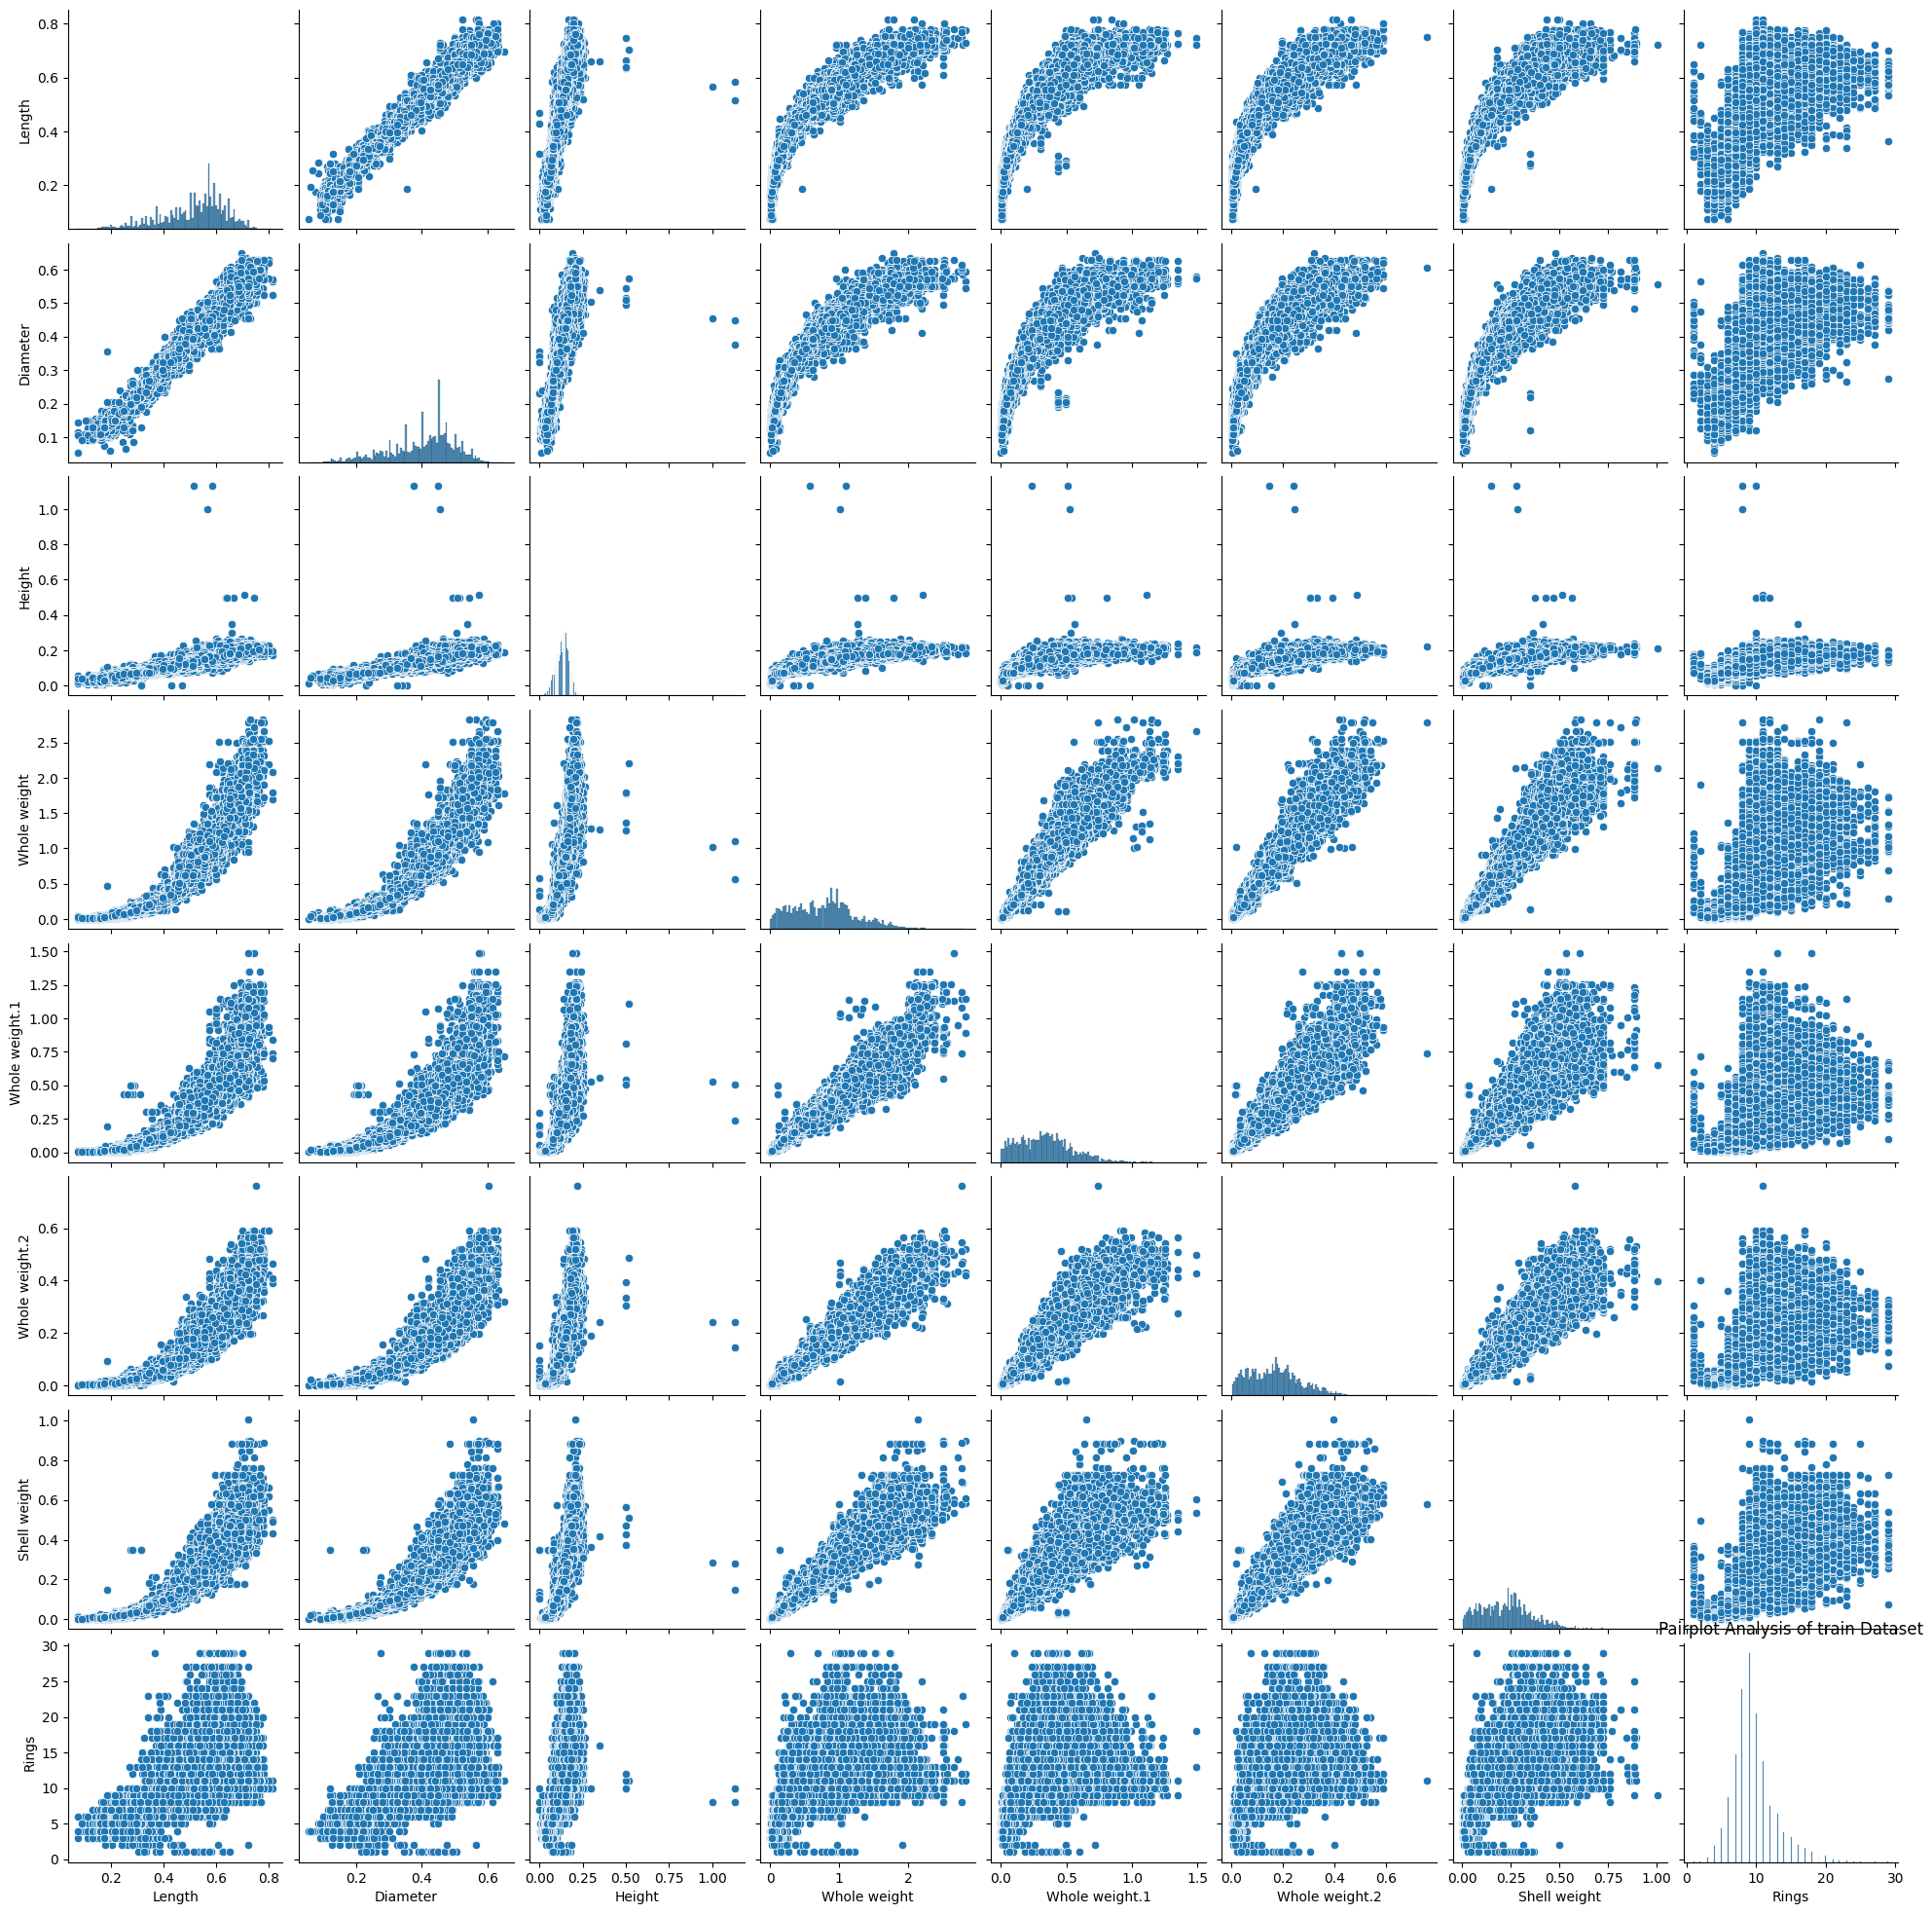

In [7]:
warnings.filterwarnings("ignore")
sns.pairplot(train)
plt.title('Pairplot Analysis of train Dataset')
plt.show()

## Model 1- Whole Weight

In [8]:
X = train['Whole weight']
y = train['Rings']

In [9]:
models = [MS([poly('Whole weight', degree=d)]) for d in range(1,8)]
Xs = [model.fit_transform(train) for model in models]
anova_lm(*[sm.OLS(y, X_).fit() for X_ in Xs])

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,90613.0,565833.131544,0.0,NaN,NaN,NaN
1,90612.0,527155.285486,1.0,38677.846059,6691.520085,0.000000e+00
2,90611.0,525526.269830,1.0,1629.015655,281.830352,3.735818e-63
3,90610.0,525152.956451,1.0,373.313379,64.585654,9.352831e-16
4,90609.0,525054.511319,1.0,98.445132,17.031651,3.679471e-05
5,90608.0,525054.364933,1.0,0.146385,0.025326,8.735588e-01
6,90607.0,523720.104473,1.0,1334.260461,230.835778,4.543276e-52


In [10]:
poly_ww = MS([poly('Whole weight', degree=5)]).fit(train)
M = sm.OLS(y, poly_ww.transform(train)).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,9.6968,0.008,1212.584,0.0
"poly(Whole weight, degree=5)[0]",590.1824,2.407,245.171,0.0
"poly(Whole weight, degree=5)[1]",-196.6668,2.407,-81.699,0.0
"poly(Whole weight, degree=5)[2]",40.3611,2.407,16.767,0.0
"poly(Whole weight, degree=5)[3]",-19.3213,2.407,-8.026,0.0
"poly(Whole weight, degree=5)[4]",9.9220,2.407,4.122,0.0


In [11]:
ww_grid = np.linspace(X.min(),
                       X.max(),
                       100)
ww_df = pd.DataFrame({'Whole weight': ww_grid})

<Axes: title={'center': 'Degree-5 Polynomial'}, xlabel='Whole Weight', ylabel='Rings'>

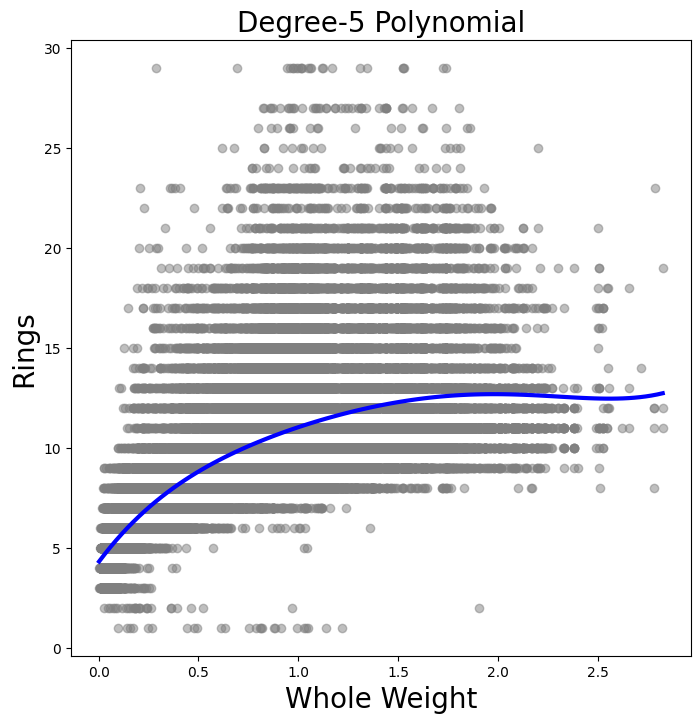

In [12]:
plot_fit(ww_df, X, poly_ww, 'Degree-5 Polynomial', 'Whole Weight')

In [13]:
print(M.summary())

                            OLS Regression Results                            
Dep. Variable:                  Rings   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.426
Method:                 Least Squares   F-statistic:                 1.343e+04
Date:                Mon, 03 Feb 2025   Prob (F-statistic):               0.00
Time:                        02:17:57   Log-Likelihood:            -2.0818e+05
No. Observations:               90615   AIC:                         4.164e+05
Df Residuals:                   90609   BIC:                         4.164e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
intercept 

In [14]:
whole_weight_poly_test = poly_ww.transform(test[['Whole weight']])
predictions = M.predict(sm.add_constant(whole_weight_poly_test))

In [15]:
predictions

0        11.724350
1        10.969961
2        10.446763
3        10.579833
4         7.870088
           ...    
60406     6.331826
60407    10.466353
60408    11.407258
60409    12.269506
60410     8.270954
Length: 60411, dtype: float64

In [16]:
submission_1 = pd.DataFrame({'id':test['id'], 'Rings':predictions})
submission_1.describe()

,id,Rings
count,60411.000000,60411.000000
mean,120820.000000,9.702642
std,17439.297893,2.066421
min,90615.000000,4.311085
25%,105717.500000,8.301152
50%,120820.000000,10.294364
75%,135922.500000,11.251145
max,151025.000000,12.724197


In [17]:
submission_1.to_csv('submission_1.csv', index=False)

## Model 2- Length

In [18]:
X = train['Length']
y = train['Rings']

In [19]:
models = [MS([poly('Length', degree=d)]) for d in range(1,8)]
Xs = [model.fit_transform(train) for model in models]
anova_lm(*[sm.OLS(y, X_).fit() for X_ in Xs])

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,90613.0,558445.448084,0.0,NaN,NaN,NaN
1,90612.0,557749.964083,1.0,695.484001,113.818167,1.481081e-26
2,90611.0,554399.911192,1.0,3350.052891,548.246804,6.940732e-121
3,90610.0,554285.804834,1.0,114.106358,18.673868,1.552585e-05
4,90609.0,554190.151922,1.0,95.652912,15.653903,7.611332e-05
5,90608.0,554134.660075,1.0,55.491847,9.081417,2.582912e-03
6,90607.0,553652.552519,1.0,482.107556,78.898434,6.654746e-19


In [20]:
poly_len = MS([poly('Length', degree=6)]).fit(train)
M = sm.OLS(y, poly_len.transform(train)).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,9.6968,0.008,1180.331,0.000
"poly(Length, degree=6)[0]",596.4084,2.473,241.168,0.000
"poly(Length, degree=6)[1]",-26.3720,2.473,-10.664,0.000
"poly(Length, degree=6)[2]",-57.8796,2.473,-23.405,0.000
"poly(Length, degree=6)[3]",-10.6821,2.473,-4.319,0.000
"poly(Length, degree=6)[4]",9.7802,2.473,3.955,0.000
"poly(Length, degree=6)[5]",7.4493,2.473,3.012,0.003


In [21]:
len_grid = np.linspace(X.min(),
                       X.max(),
                       1000)
len_df = pd.DataFrame({'Length': ww_grid})

<Axes: title={'center': 'Degree-5 Polynomial'}, xlabel='Length', ylabel='Rings'>

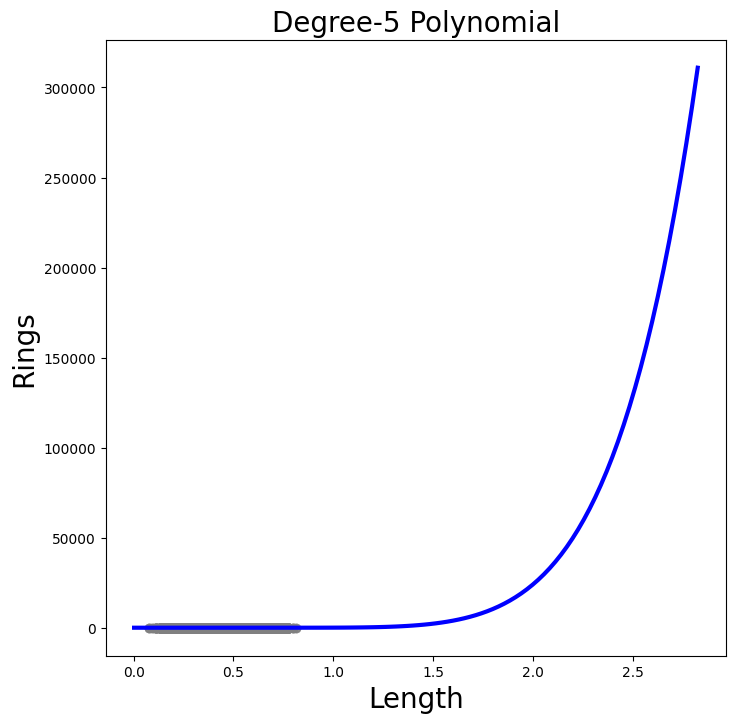

In [22]:
plot_fit(len_df, X, poly_len, 'Degree-5 Polynomial', 'Length')

In [23]:
print(M.summary())

                            OLS Regression Results                            
Dep. Variable:                  Rings   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.394
Method:                 Least Squares   F-statistic:                     9811.
Date:                Mon, 03 Feb 2025   Prob (F-statistic):               0.00
Time:                        02:18:00   Log-Likelihood:            -2.1062e+05
No. Observations:               90615   AIC:                         4.213e+05
Df Residuals:                   90608   BIC:                         4.213e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
intercept             

In [24]:
length_poly_test = poly_len.transform(test[['Length']])
predictions = M.predict(sm.add_constant(length_poly_test))

In [25]:
submission_2 = pd.DataFrame({'id':test['id'], 'Rings':predictions})
submission_2.describe()

,id,Rings
count,60411.000000,60411.000000
mean,120820.000000,9.703187
std,17439.297893,1.984721
min,90615.000000,3.584906
25%,105717.500000,8.487334
50%,120820.000000,10.351639
75%,135922.500000,11.247331
max,151025.000000,13.175278


In [26]:
submission_2.to_csv('submission_2.csv', index=False)